## Vanilla Softmax

Built with reference to http://cs231n.github.io/assignments2017/assignment1/ 

- Develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [14]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from IPython.core.debugger import set_trace

In [4]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt


class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        scores = None
        #############################################################################
        # TODO: Perform the forward pass, computing the class scores for the input. #
        # Store the result in the scores variable, which should be an array of      #
        # shape (N, C).                                                             #
        #############################################################################

        z1 = np.dot(X, W1) + b1
        a1 = np.maximum(0, z1)
        scores = np.dot(a1, W2) + b2

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = 0.0
        #############################################################################
        # TODO: Finish the forward pass, and compute the loss. This should include  #
        # both the data loss and L2 regularization for W1 and W2. Store the result  #
        # in the variable loss, which should be a scalar. Use the Softmax           #
        # classifier loss.                                                          #
        #############################################################################

        scores -= np.max(scores, axis=1, keepdims=True)
        probs = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)
        correct_logprobs = -np.log(probs[range(N),y])
        data_loss = np.sum(correct_logprobs)/N
        
        reg_loss = 0.5 * reg * np.sum(W1 * W1) + 0.5 * reg * np.sum(W2 * W2)
        loss = data_loss + reg_loss

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        # Backward pass: compute gradients
        grads = {}
        #############################################################################
        # TODO: Compute the backward pass, computing the derivatives of the weights #
        # and biases. Store the results in the grads dictionary. For example,       #
        # grads['W1'] should store the gradient on W1, and be a matrix of same size #
        #############################################################################

        # gradient dscores 
        dscores = probs.copy()
        dscores[range(N), y] -= 1
        dscores /= N
             
        # W2 and b2
        grads['W2'] = np.dot(a1.T, dscores)
        grads['b2'] = np.sum(dscores, axis=0)

        # next backprop into hidden layer
        dhidden = np.dot(dscores, W2.T)
        
        # backprop the ReLU non-linearity
        dhidden[a1 <= 0] = 0
        
        # W1 and b1
        grads['W1'] = np.dot(X.T, dhidden)
        grads['b1'] = np.sum(dhidden, axis=0)
        
        # Add regularization
        grads['W2'] += reg * W2
        grads['W1'] += reg * W1

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        return loss, grads

    def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100,
            batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None

      #########################################################################
      # TODO: Create a random minibatch of training data and labels, storing  #
      # them in X_batch and y_batch respectively.                             #
      #########################################################################

      # Only take the first 'batch_size' elements.
            batch_indices = np.random.choice(num_train, batch_size)
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]

      #########################################################################
      #                             END OF YOUR CODE                          #
      #########################################################################

      # Compute loss and gradients using the current minibatch.
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

      #########################################################################
      # TODO: Use the gradients in the grads dictionary to update the         #
      # parameters of the network (stored in the dictionary self.params)      #
      # using stochastic gradient descent. You'll need to use the gradients   #
      # stored in the grads dictionary defined above.                         #
      #########################################################################

      # Vanilla gradient descent update.
            self.params['W1'] += -learning_rate * grads['W1']
            self.params['b1'] += -learning_rate * grads['b1']
            self.params['W2'] += -learning_rate * grads['W2']
            self.params['b2'] += -learning_rate * grads['b2']

      #########################################################################
      #                             END OF YOUR CODE                          #
      #########################################################################

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
          the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
          to have class c, where 0 <= c < C.
        """
        y_pred = None

        ###########################################################################
        # TODO: Implement this function; it should be VERY simple!                #
        ###########################################################################

        # Get the index of highest score, this is our predicted class.
        y_pred = np.argmax(self.loss(X), axis=1)

        ###########################################################################
        #                              END OF YOUR CODE                           #
        ###########################################################################

        return y_pred




In [5]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

### Forward pass: Compute Scores

In [6]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores))) 

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]
correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]
Difference between your scores and correct scores:
3.6802720745909845e-08


### Foward pass: Compute Loss

In [7]:
loss, _ = net.loss(X, y, reg=0.1)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:') 
print(np.sum(np.abs(loss - correct_loss))) 

Difference between your loss and correct loss:
1.7985612998927536e-13


### Backward Pass

In [8]:
from gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.1)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.1)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))) 

W2 max relative error: 3.440708e-09
b2 max relative error: 4.447625e-11
W1 max relative error: 3.561318e-09
b1 max relative error: 2.738421e-09


### Train the network

Final training loss:  0.017149607938732093


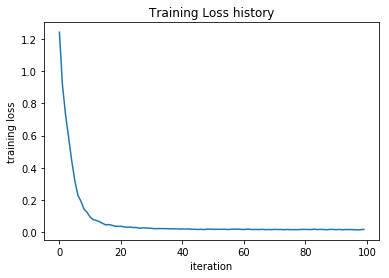

In [9]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=1e-5,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1]) 

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

### Load Data

In [10]:
from data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'data/cifar10/'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape) 
print('Validation data shape: ', X_val.shape) 
print('Validation labels shape: ', y_val.shape) 
print('Test data shape: ', X_test.shape) 
print('Test labels shape: ', y_test.shape) 

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


### Train the network

In [11]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=400,
            learning_rate=2e-3, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1000: loss 2.302773
iteration 100 / 1000: loss 1.745207
iteration 200 / 1000: loss 1.656761
iteration 300 / 1000: loss 1.637897
iteration 400 / 1000: loss 1.432480
iteration 500 / 1000: loss 1.521185
iteration 600 / 1000: loss 1.669321
iteration 700 / 1000: loss 1.468802
iteration 800 / 1000: loss 1.558320
iteration 900 / 1000: loss 1.499395
Validation accuracy:  0.477


### Debug the training

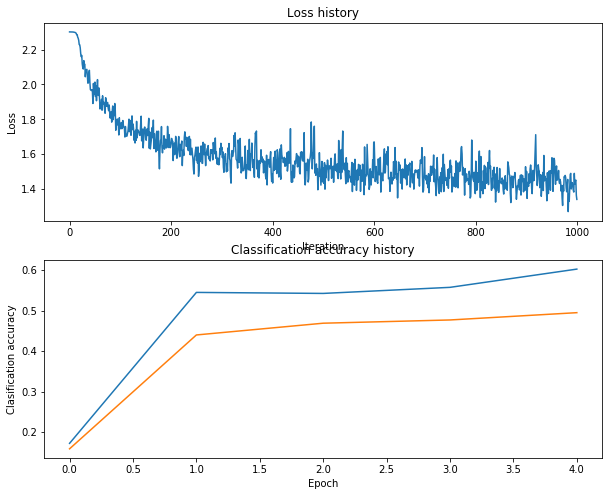

In [15]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

### Tune the hyperparameters

In [17]:
best_net = None # store the best model into this 
#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
best_val = -1
best_stats = None
input_size = 32 * 32 * 3
hidden_size = 100
num_classes = 10
learning_rates = [2e-3, 5e-3]
regularization_strengths = [0.2, 0.4, 0.6]
results = {} 
iters = 1000 
for lr in learning_rates:
    for rs in regularization_strengths:
        net = TwoLayerNet(input_size, hidden_size, num_classes)

        # Train the network
        stats = net.train(X_train, y_train, X_val, y_val,
                    num_iters=iters, batch_size=400,
                    learning_rate=lr, learning_rate_decay=0.95,
                    reg=rs)
        
        y_train_pred = net.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        y_val_pred = net.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(lr, rs)] = (acc_train, acc_val)
        
        if best_val < acc_val:
            best_stats = stats
            best_val = acc_val
            best_net = net
            
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val   ) 

#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################


/Users/JackyCSL/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:103: RuntimeWarning: divide by zero encountered in log


lr 2.000000e-03 reg 2.000000e-01 train accuracy: 0.524673 val accuracy: 0.478000
lr 2.000000e-03 reg 4.000000e-01 train accuracy: 0.509245 val accuracy: 0.485000
lr 2.000000e-03 reg 6.000000e-01 train accuracy: 0.541429 val accuracy: 0.528000
lr 5.000000e-03 reg 2.000000e-01 train accuracy: 0.116143 val accuracy: 0.113000
lr 5.000000e-03 reg 4.000000e-01 train accuracy: 0.115592 val accuracy: 0.118000
lr 5.000000e-03 reg 6.000000e-01 train accuracy: 0.114612 val accuracy: 0.109000
best validation accuracy achieved during cross-validation: 0.528000


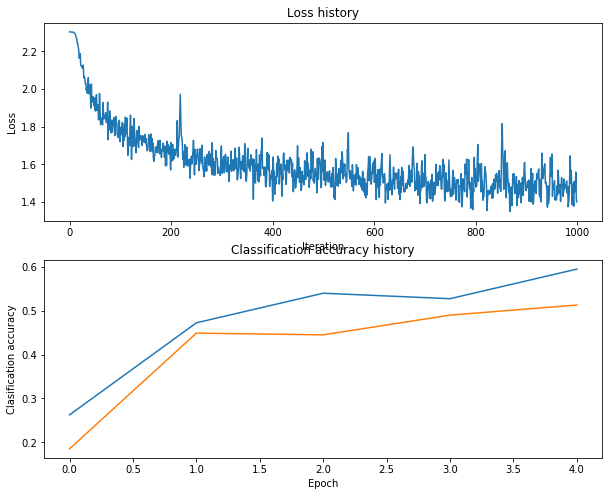

In [18]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

### Run the test set

In [19]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.511
